In [1]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from scipy import ndimage
import cv2

In [2]:
sample_dir = os.path.expanduser("~")+'/repos/datasetGAN_release/datasetGAN/model_dir/new_echo/samples'
print(sample_dir)
save_dir = 'data/2D_synthetic'
print(save_dir)

/home/tchan/repos/datasetGAN_release/datasetGAN/model_dir/new_echo/samples
data/2D_synthetic


In [5]:
sample_dir = os.path.expanduser("~")+'/data/echo_testers'
print(sample_dir)
save_dir = os.path.expanduser("~")+'/data/echo_testers'
print(save_dir)
outputs_dir = os.path.expanduser("~")+'/data/echo_outputs'
print(outputs_dir)

/home/tchan/data/echo_testers
/home/tchan/data/echo_testers
/home/tchan/data/echo_outputs


In [4]:
%pwd

'/home/tchan/repos/echo-4d'

In [6]:
for img_path in tqdm(glob.glob(sample_dir + '/*.png')):
    img = np.array(Image.open(img_path))
    if 'label_' in img_path:
        # print('label')
        img = cv2.resize(img, dsize=(128, 128)) #bilinear by default
        img = np.expand_dims(img, 2)#necessary for nn-unet processing to be in shape of 3d img
        newpath = '{}/labelsTr/{}.nii.gz'.format(save_dir, os.path.splitext(os.path.split(img_path)[1])[0].replace('label_',''))
    else:
        # print('image')
        img = np.expand_dims(img, 2)#necessary for nn-unet processing to be in shape of 3d img
        img = np.mean(img, axis=3)
        newpath = '{}/imagesTr/{}_0000.nii.gz'.format(save_dir, os.path.splitext(os.path.split(img_path)[1])[0])
    newimg = nib.Nifti1Image(img, np.eye(4))
    nib.save(newimg, newpath)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 332.39it/s]


In [7]:
for img_path in tqdm(sorted(glob.glob(outputs_dir+'/*.nii.gz'))):
    img = nib.load(img_path)
    imgdata = img.get_fdata()
    Image.fromarray(np.squeeze((imgdata*15).astype(np.uint8), axis=2)).save(os.path.splitext(img_path)[0]+'.png', format='png')

# for img_path in tqdm(sorted(glob.glob(sample_dir+'/imagesTr/*.nii.gz'))):
#     img = nib.load(img_path)
#     imgdata = img.get_fdata()
#     Image.fromarray(np.squeeze((imgdata).astype(np.uint8), axis=2)).save(os.path.splitext(img_path)[0]+'.png', format='png')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 782.83it/s]


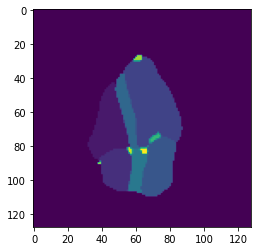

In [27]:
plt.imshow((imgdata*15).astype(np.uint8))




Make dataset.json file

task_folder_name is the directory of the task
train_dir and test_dir are the paths to the train labels and test labels

In [6]:
task_folder_name = os.path.expanduser("~")+'/../../data1/nnUNet_raw/nnUNet_raw_data/Task800_4Chamber'
train_dir = task_folder_name+'/labelsTr'
test_dir = task_folder_name+'/imagesTs'

import json

from collections import OrderedDict

overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = "Task800_4Chamber"
    json_dict['description'] = "segmentation preliminary dataset for 4 chamber synthetic echo"
    json_dict['tensorImageSize'] = "2D"
    json_dict['reference'] = "none"
    json_dict['licence'] = "none"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "echo"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = OrderedDict()
    json_dict['labels']['00'] = 'background'
    json_dict['labels']['01'] = '1'
    json_dict['labels']['02'] = '2'
    json_dict['labels']['03'] = '3'
    json_dict['labels']['04'] = '4'
    json_dict['labels']['05'] = '5'
    json_dict['labels']['06'] = '6'
    json_dict['labels']['07'] = '7'
    json_dict['labels']['08'] = '8'
    json_dict['labels']['09'] = '9'
    json_dict['labels']['10'] = '10'
    json_dict['labels']['11'] = '11'
    json_dict['labels']['12'] = '12'
    json_dict['labels']['13'] = '13'
    json_dict['labels']['14'] = '14'
    json_dict['labels']['15'] = '15'
    
    train_ids = os.listdir(train_dir)
    train_ids = sorted([os.path.splitext(os.path.splitext(id)[0])[0] for id in train_ids])
    test_ids = os.listdir(test_dir)
    test_ids = sorted([os.path.splitext(os.path.splitext(id)[0])[0] for id in test_ids])
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i in train_ids]
    
    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


In [5]:
#CHECK image size

import SimpleITK as sitk
print(sitk.GetArrayFromImage(sitk.ReadImage('data/2D_synthetic/imagesTr/0_0000.nii.gz')).shape)
print(sitk.GetArrayFromImage(sitk.ReadImage('data/2D_synthetic/labelsTr/0.nii.gz')).shape)

(1, 128, 128)
(1, 128, 128)
